In [1]:
import numpy as np
import random
import os
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [83]:
import numpy as np

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

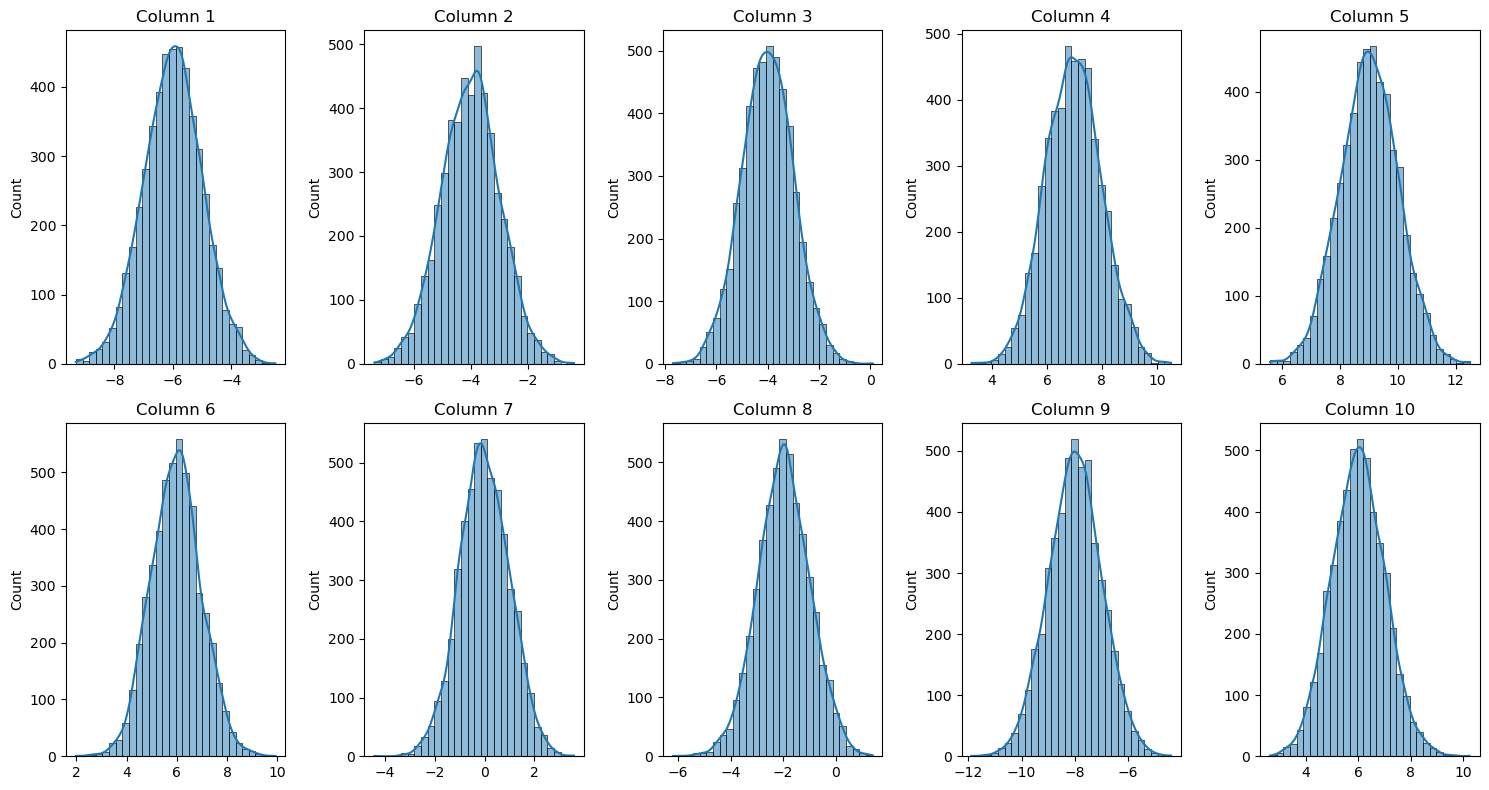

In [84]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data_size = 5000
np.random.seed(64)
# Generate a random integer array 'a' with shape (10, 1)
a = np.random.randint(-10, 10, size=(10, 1))

# Flatten 'a' to create the mean vector for the multivariate normal distribution
mean = a.flatten()

# Generate multivariate normal data 'b' with shape (1000, 10)
b = np.random.multivariate_normal(mean=mean, cov=np.eye(10), size=data_size)

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Flatten the 2x5 axes array for easy iteration
axes = axes.flatten()

# Loop through each column of 'b' and plot its histogram on the corresponding subplot
for i in range(10):
    sns.histplot(b[:, i], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Column {i+1}')  # Set the title for each subplot

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [85]:
class Backbone(nn.Module):
    def __init__(self, n_steps, input_dim = 10):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.GELU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, 32)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32, 64),
            nn.GELU(),
            
            nn.Linear(64, 32),
            nn.GELU(),
            
            nn.Linear(32, input_dim),
        )
    def forward(self, x, idx):        
        x = self.linear_model2(self.linear_model1(x) + self.embedding_layer(idx))
        return x


In [86]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim = b.shape[1]):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = Backbone(T, input_dim)
        
        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            

            
        output = self.backbone(x_tilde, idx)
        
        return (output, epsilon, used_alpha_bars) if get_target else output
        

In [87]:
class DiffusionProcessDDIM():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape, eta, tau = 5, scheduling = 'uniform'):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        eta           : coefficient of sigma
        tau           : accelerating of diffusion process
        scheduling    : scheduling mode of diffusion process
        '''
        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])

        self.shape = shape
        self.sigmas = torch.sqrt((1 - self.alpha_prev_bars) / (1 - self.alpha_bars)) * torch.sqrt(1 - (self.alpha_bars / self.alpha_prev_bars))
        self.diffusion_fn = diffusion_fn
        self.device = device
        self.eta = eta
        self.tau = tau
        self.scheduling = scheduling
        
    def _get_process_scheduling(self, reverse = True):
        if self.scheduling == 'uniform':
            diffusion_process = list(range(0, len(self.alpha_bars), self.tau)) + [len(self.alpha_bars)-1]
        elif self.scheduling == 'exp':
            diffusion_process = (np.linspace(0, np.sqrt(len(self.alpha_bars)* 0.8), self.tau)** 2)
            diffusion_process = [int(s) for s in list(diffusion_process)] + [len(self.alpha_bars)-1]
        else:
            assert 'Not Implementation'
            
        
        diffusion_process = zip(reversed(diffusion_process[:-1]), reversed(diffusion_process[1:])) if reverse else zip(diffusion_process[1:], diffusion_process[:-1])
        return diffusion_process
            

    
    def _one_reverse_diffusion_step(self, x):
        '''
        x   : perturbated data (输入被加噪的样本)
        '''
        diffusion_process = self._get_process_scheduling(reverse=True)  # 获取时间步调度
        for prev_idx, idx in diffusion_process:
            self.diffusion_fn.eval()  # 设置模型为评估模式
            
            predict_epsilon = self.diffusion_fn(x, idx)
            
            predicted_x0 =  (
                (x - torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon) 
                / torch.sqrt(self.alpha_bars[idx])
            )
            
            # 确定性更新方向
            direction_pointing_to_xt = torch.sqrt(1 - self.alpha_bars[prev_idx]) * (predict_epsilon)
            
            x = torch.sqrt(self.alpha_bars[prev_idx]) *predicted_x0 + direction_pointing_to_xt

            yield x

    @torch.no_grad()
    def sampling(self, sampling_number, sample=None, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        if sample==None:
            sample = torch.randn([sampling_number,self.shape]).to(device = self.device)
            
        sampling_list = []
        final = None
        for sample in self._one_reverse_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

    
    @torch.no_grad()
    def probabilityflow(self, x, reverse):
        '''
        reverse : if True, backward(noise -> data) else forward(data -> noise)
        '''
        def reparameterize_sigma(idx):
            return torch.sqrt( (1-self.alpha_bars[idx]) / self.alpha_bars[idx] )
        def reparameterize_x(x, idx):
            return x / torch.sqrt(self.alpha_bars[idx])
        
        diffusion_process = self._get_process_scheduling(reverse = reverse)
        for idx_delta_t, idx in diffusion_process:
            self.diffusion_fn.eval()
            x_bar_delta_t = reparameterize_x(x, idx) + 0.5 * (reparameterize_sigma(idx_delta_t)**2 - reparameterize_sigma(idx)**2) / reparameterize_sigma(idx) * self.diffusion_fn(x, idx)
            x = x_bar_delta_t * torch.sqrt(self.alpha_bars[idx_delta_t])

        return x

In [88]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [89]:

total_iteration = 1000
current_iteration = 0
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50

beta_1 = 1e-4
beta_T = 0.02
T = 1000
device = torch.device('cuda:0')
eta = 1
tau = 1
model = Model(device, beta_1, beta_T, T )



In [90]:
def traincon_ddim(model,optimizer,num_epochs,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            batch = batch.cuda()
            loss = model.loss_fn(batch)
            whole_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.update(loss.item())
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                batch = val_batch.cuda()
                val_loss+=model.loss_fn(batch)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

In [91]:
X_train_5 = np.array(b[:3000,:], dtype=np.float32)
X_val_5 = np.array(b[3000:4000,:], dtype=np.float32)
X_test_5 = np.array(b[4000:5000,:], dtype=np.float32)
sc = StandardScaler()
sca_X_train_5 = sc.fit_transform(X_train_5)
sca_X_val_5 = sc.fit_transform(X_val_5)
sca_X_test_5 = sc.fit_transform(X_test_5)
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=64, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=64, shuffle=True)
sca_test_loader_5 = DataLoader(sca_X_test_5, batch_size=64, shuffle=True)

In [92]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = Model(device, beta_1, beta_T, T)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)

In [93]:
traincon_ddim(model,optim,500,sca_traindata_loader_5,sca_valdata_loader_5,100)

epoch: 0, Train Loss: 0.8740, Val Loss: 0.7399
epoch: 0, find new best loss: Train Loss: 0.7399
----------
epoch: 1, find new best loss: Train Loss: 0.6163
----------
epoch: 2, find new best loss: Train Loss: 0.5541
----------
epoch: 3, find new best loss: Train Loss: 0.5129
----------
epoch: 4, find new best loss: Train Loss: 0.4629
----------
epoch: 6, find new best loss: Train Loss: 0.4540
----------
epoch: 8, find new best loss: Train Loss: 0.4525
----------
epoch: 9, find new best loss: Train Loss: 0.4268
----------
epoch: 10, find new best loss: Train Loss: 0.4125
----------
epoch: 11, find new best loss: Train Loss: 0.4036
----------
epoch: 13, find new best loss: Train Loss: 0.3773
----------
epoch: 14, find new best loss: Train Loss: 0.3700
----------
epoch: 17, find new best loss: Train Loss: 0.3669
----------
epoch: 18, find new best loss: Train Loss: 0.3328
----------
epoch: 20, Train Loss: 0.3432, Val Loss: 0.3280
epoch: 20, find new best loss: Train Loss: 0.3280
---------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

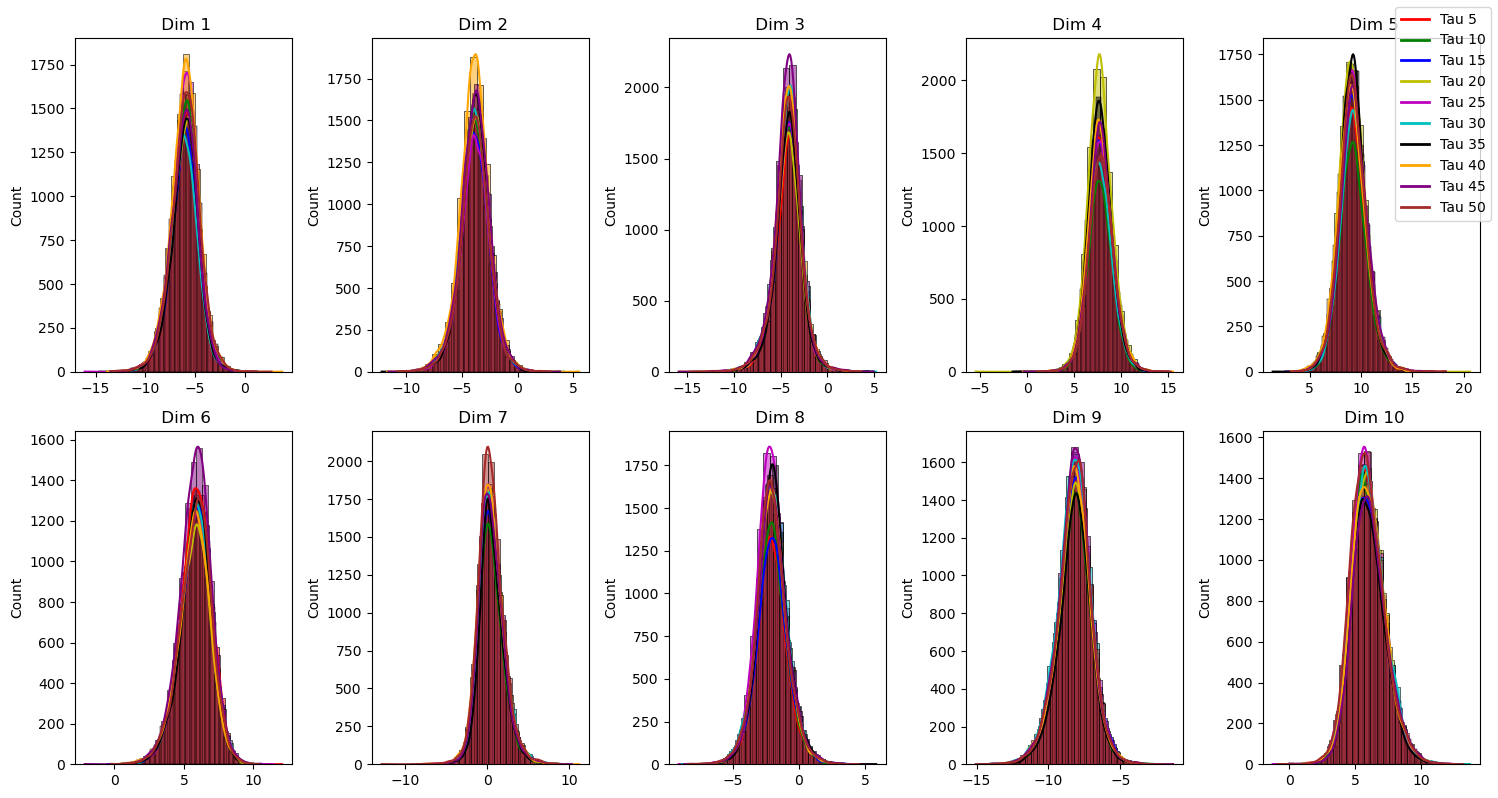

In [100]:
taulist = [5 * i for i in range(1, 11)]
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # 创建一个10x10的子图网格
axes = axes.flatten()
samplelist = []
for idx, tau in enumerate(taulist):
    process = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, X_train_5.shape[1], eta, tau=tau)
    only_final = True
    sampling_number = 10000
    sample = process.sampling(sampling_number, only_final=True)
    sample = sc.inverse_transform(sample.cpu().detach().numpy())
    samplelist.append(sample)

# 在对应的子图上绘制直方图
colourlist = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'orange', 'purple', 'brown']
for j in range(10):
    for i in range(10):
        sns.histplot(samplelist[i][:, j], kde=True, bins=30, ax=axes[j], color=colourlist[i])
    axes[j].set_title(f' Dim {j+1}')  # 设置子图标题

# 调整布局以防止重叠
plt.tight_layout()

# 添加图例
handles = [plt.Line2D([0], [0], color=colourlist[i], lw=2) for i in range(10)]
labels = [f'Tau {taulist[i]}' for i in range(10)]
fig.legend(handles, labels, loc='upper right')

# 显示所有子图
plt.show()
